# Calibration days identification
NOTE: python 3.7 installed locally, remote version  Python 3.7.7 on console?
**BEWARE** all precise locations to be masked even in folder path

In [1]:
#separated in case added later
PYRANOMETERS_ALL = ["Glamorgan", "East Midlands",  "Lazio A", "Lazio B",
           "Trentino Alto Adige tilted", "Trentino Alto Adige horizontal"]
#re-executing only final functions and visualisation outputs using cached variables
#execute=["Glamorgan", "Trentino Alto Adige tilted", "Trentino Alto Adige horizontal"]
execute = PYRANOMETERS_ALL

In [2]:
#calculated during the execution
#cleaned dataframes
dfcs = {}
#solar libraries
sls = {}

In [3]:
#utc dataframes
dfus = {}

In [4]:
#from preliminary analysis
#initial timezone
tzis = dict(zip(PYRANOMETERS_ALL, ["utc"]*2+["Europe/Rome"]*4))
#datetime delays, summer before winter to keep same convention
dtdsws = dict(zip(PYRANOMETERS_ALL, [None]*2+[(-3600, -7200)]*2+[(-450, -450)]*2))

pycharm setup
https://stackoverflow.com/questions/36137671/pycharm-running-out-of-memory
-Xms128m to 512
Disabling plugin: as many as possible @fm beware java since not working after
https://intellij-support.jetbrains.com/hc/en-us/community/posts/115000459084-2017-2-update-running-out-of-memory-while-indexing-project
excluding resources

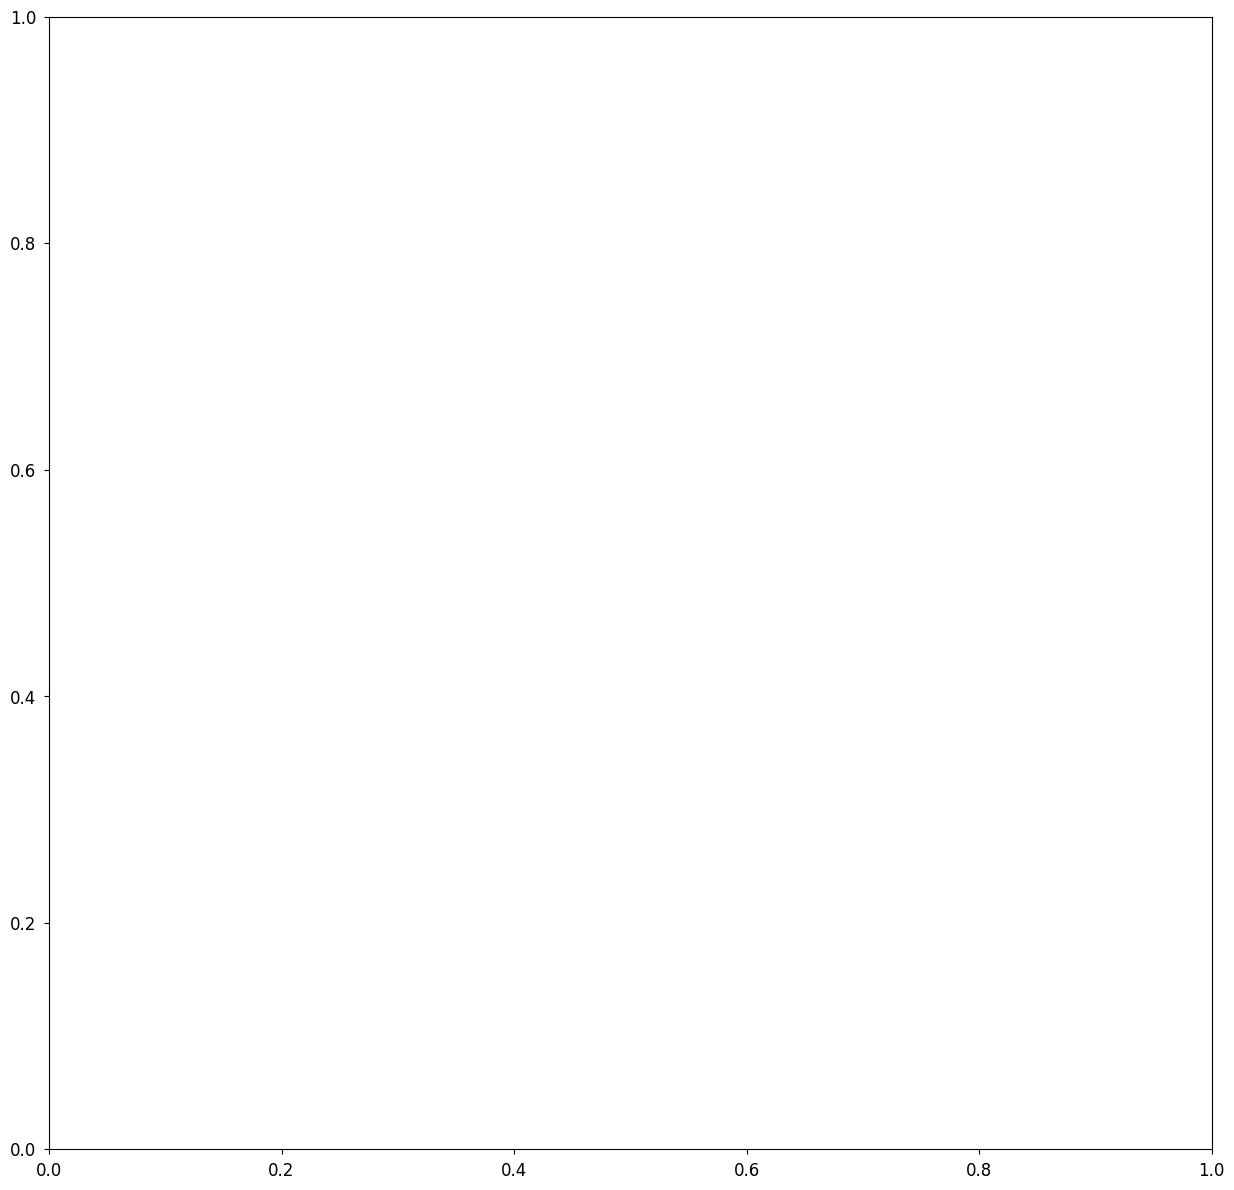

In [5]:
import sys

sys.path.insert(0, r'C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance\source')

import pandas as pd

#versione requiring array and not datetimeindex
#https://pvlib-python.readthedocs.io/en/stable/_modules/pvlib/spa.html

#from clear_sky import datetime_to_utc
import datetime
#no calendar used, instead datetime and strftime used for conversion from int to string
#import calendar
#calendar.month_abbr[month_number]


from typing import List, Dict

from os import getcwd #, listdir
from os.path import join, dirname

import data_operations as dtop
import irradiance_analysis as iran
import irradiance_plot as irplt

import matplotlib.pyplot as plt

#for commonly used decorators
import decorators
#for nb specific decorators
import functools


import clear_sky as csky
from clear_sky import SolarLibrary

import matplotlib as mpl

from empiricaldist import Pmf, Cdf
#https://nbviewer.jupyter.org/github/AllenDowney/empiricaldist/blob/master/empiricaldist/dist_demo.ipynb
#https://campus.datacamp.com/courses/exploratory-data-analysis-in-python/distributions?ex=2

In [6]:
#excluding store to verify if cause problems
#retrieving stored variables
%store -r
#automatically reload
%load_ext autoreload
# autoreload 0 if deactivated 2 if all modules but excluded -
%autoreload 1
#interrupt when needed
%aimport data_operations, decorators, matplotlib, clear_sky, irradiance_analysis, irradiance_plot

#https://stackoverflow.com/questions/22934204/how-to-clear-variables-in-ipython
%reset

#https://ipython.readthedocs.io/en/stable/config/extensions/storemagic.html?highlight=store#IPython.extensions.storemagic.StoreMagics.store
# not working
%store -z

#remove unwanted cache
%store -d spam ax
%store -d _, __
%store -d cmp_sp_c_nd, cmp_sp_r_nd, cmp_sp_rm1nd
%store -d df_bzc, df_bzc30
%store -d dly_bz0c, dly_bz0cs, dly_bz30c, dly_bz30cs, dly_c, dly_r, dly r_s, dly_rm1_tz, dly_rm1cs, dly_rm4, dly_rm4cs
%store -d df_duplicates0, df_duplicates1, df_duplicates30, df_duplicates4, duplicates_c, duplicates_r

In [7]:
#TBC which parameters still relevant

pd.set_option('display.max_columns', None)
#to solve copy warning
pd.set_option('mode.chained_assignment','raise')
print(f'Matplotlib conf file at: {mpl.matplotlib_fname()}', plt.style.available)
#Tmp removed not working on jupyter
#mpl.style.use(['seaborn-paper', 'thesis'])

#DEV NOTE 16/5/21: reading folders to be masked ?
PV_FOLDER_C=r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/_Research_Master/_Data Sources/Glamorgan/"
PV_FILE_C=r"devicedata_0921.csv"
ISC_IRRADIANCE_FILES_FOLDER = join(dirname(getcwd())+r"/assets/isc_irradiance_files/")
L_FOLDER=  r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/_Research_Master/_Data Sources/Lazio/"
L_PYR_C1="Pyranometer Cab 1_fm.csv"
L_PYR_C4="Pyranometer Cab 4_fm.csv"
TAA_FOLDER=  r"C:/Users/wsfm/OneDrive - Loughborough University/_Personal_Backup/_Research_Master/_Data Sources/Trentino Alto Adige/"
TAA_PYR="20110201_20190228_pc_Si6.csv"
#title for graphs
disconnection_title = f'Hourly disconnection analysis of %s from %s to %s'
delay_title = f'Daily comparison against sunpath of %s from %s to %s'
distribution_title = f'Monthly distribution of time difference between %s measurement'
#saving file
CSVS_FOLDER =  join(dirname(getcwd())+r"/outputs/csvs/")
ASSETS_FOLDER = join(dirname(getcwd()) + r"/assets/")


#parameters and labels
DELAY_PARAMETERS_ALL = {'delay_first_h':'sunrise and first',
             'delay_last_h':'sunset and last',
            'delay_transit_h':'sun transit and max',
            'delay_centre_h':'the centre and max'}

#Module position is retrieved through [digimap](#https://digimap.edina.ac.uk/)
LATITUDE = 52.7616
#negative longitude based on solar convention
LONGITUDE =  -1.2406
ALTITUDE = 79
PRESSURE = 101325.
TEMPERATURE = 12
DELTA_T = 67.0
ATMOS_REFRACT = 0.5667
TRANSMITTANCE = 0.5
GMIN = 20
SURFACE_ZENITH = 34
SURFACE_AZIMUTH = 180
NUMTHREADS = 4
#tbc where used
delta_t = DELTA_T
observer_longitude = LONGITUDE
observer_latitude = LATITUDE
observer_elevation = ALTITUDE
local_pressure =PRESSURE
local_temp = TEMPERATURE
atmos_refract = ATMOS_REFRACT
numthreads = NUMTHREADS

Matplotlib conf file at: c:\users\wsfm\onedrive - loughborough university\_personal_backup\python_repositories\venv\lib\site-packages\matplotlib\mpl-data\matplotlibrc ['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10', 'thesis']


In [8]:
#decorators
describe_with_tukey_fence = decorators.add_tukey_fences(pd.DataFrame.describe)
plt_savefig = decorators.change_savefig(plt.savefig)
#removing white box appearing at the end ?
plt.close()
pd.read_csv = decorators.timer(pd.read_csv)
#common functions used during the NB


#function to extract hidden location info
def get_com_sl(func):
    #plt.show()
    @functools.wraps(func)
    def send_com_info(folder:str, *args, **kwargs):
        com_info = pd.read_csv(filepath_or_buffer=folder+'pv_com_info.csv', delimiter=",",header=0, index_col=0)
        for i in com_info.index:
            kwargs[i] = com_info.loc[i,"value"]
        value = func(*args, **kwargs)
        return value
    return send_com_info

SolarLibrary_com = get_com_sl(SolarLibrary)


TBC visualisation could be done, risk overlaps
## Reading and cleaning dataset

### Glamrang system

https://stackoverflow.com/questions/10933838/how-to-read-a-csv-file-in-reverse-order-in-python
import csv
with open(PV_FOLDER+PV_FILE, 'r') as textfile:
    rows = list(csv.reader(textfile))
c = 0
print("First 10 rows")
for r in rows:
    print(', '.join(r))
    c += 1
    if c == 20:
        break
print("\n Last 5 rows")
c = 0
for r in reversed(rows):
    print(', '.join(r))
    c += 1
    if c == 5:
        break
print(len(rows))

In [9]:
sst = "Glamorgan"

In [10]:
if sst in execute:
    gpoa_com = pd.read_csv(filepath_or_buffer=PV_FOLDER_C+PV_FILE_C, delimiter=";",skip_blank_lines=True,header=11,nrows=597792)
    #two values to starting check time step plus end
    print(gpoa_com.head(2))
    print(gpoa_com.tail(1))

Started 'read_csv' at 2021-07-04 19:46:29.293419
Finished 'read_csv' in 0:00:00.558998 secs
                  date  p150506_c0401005002_0501001a  \
0  2015-06-03 16:29:00                        489.25   
1  2015-06-03 16:30:00                        484.61   

   p150506_c0401005002_0501011a  
0                        209.44  
1                        217.52  
                       date  p150506_c0401005002_0501001a  \
597791  2016-08-11 09:21:00                         316.2   

        p150506_c0401005002_0501011a  
597791                     1543060.0  


In [11]:
if sst in execute:
    dfcs[sst], duplicates_c =dtop.clean_df(df= gpoa_com, dt_format='%Y-%m-%d %H:%M:%S')
    print(min(dfcs[sst].dt), max(dfcs[sst].dt))

Started 'clean_df' at 2021-07-04 19:46:29.876419
Finished 'clean_df' in 0:00:00.918003 secs
2015-06-03 16:29:00 2016-08-11 09:21:00


In [12]:
if sst in execute:
    gpoa_com_info = pd.read_csv(filepath_or_buffer=PV_FOLDER_C+'pv_com_info.csv', delimiter=",",header=0, index_col=0)
    surface_zenith_com = gpoa_com_info.loc["surface_tilt","value"]#%%
    altitude_com = gpoa_com_info.loc["altitude","value"]#
    latitude_com = gpoa_com_info.loc["latitude","value"]#
    longitude_com = gpoa_com_info.loc["longitude","value"]#
    sls[sst] = SolarLibrary(latitude=latitude_com, longitude=longitude_com, altitude=altitude_com,
                     temperature=TEMPERATURE, delta_t=DELTA_T, pressure=PRESSURE,
                      surface_zenith=surface_zenith_com, surface_azimuth=SURFACE_AZIMUTH,
                      atmos_refract=ATMOS_REFRACT, transmittance=TRANSMITTANCE,
                          timezone="Europe/London")

Started 'read_csv' at 2021-07-04 19:46:32.341422
Finished 'read_csv' in 0:00:00.004000 secs


### East Midlands system

In [13]:
sst = "East Midlands"

In [14]:
if sst in execute:
    #one minute steps extracted (one second available)
    #DEV NOTE 29/5/21 based on DST days, one second rsl could be extracted from SQL if only four days taken
    #gpoa = pd.read_csv(filepath_or_buffer=join(ISC_IRRADIANCE_FILES_FOLDER,'chpoa_y15-20.csv'))
    gpoa = pd.read_csv(filepath_or_buffer=join(ISC_IRRADIANCE_FILES_FOLDER,'chpoa_y15-20m.csv'))
    print(gpoa.head(2))
    print(gpoa.tail(1))

Started 'read_csv' at 2021-07-04 19:46:32.371422
Finished 'read_csv' in 0:00:05.647007 secs
   g_cmp11_ppuk              tmstamp           date_trunc
0           0.0  24/04/2013 00:00:00  24/04/2013 00:00:00
1           0.0  24/04/2013 00:01:00  24/04/2013 00:01:00
         g_cmp11_ppuk              tmstamp           date_trunc
4025943        -1.818  21/04/2021 23:59:00  21/04/2021 23:59:00


In [15]:
if sst in execute:
    dfcs[sst], duplicates_r =dtop.clean_df(df= gpoa, dt_format='%d/%m/%Y %H:%M:%S',
                                    cln_order=["gpoa", "dt", "dt2"])
    print(min(dfcs[sst].dt), max(dfcs[sst].dt))

Started 'clean_df' at 2021-07-04 19:46:38.040431
Finished 'clean_df' in 0:00:20.821787 secs
2013-04-24 00:00:00 2021-04-21 23:59:00


In [16]:
if sst in execute:
#adding sunpath for datetimes verification
    sls[sst] = SolarLibrary(latitude=LATITUDE, longitude=LONGITUDE, altitude=ALTITUDE,
                     temperature=TEMPERATURE, delta_t=DELTA_T, pressure=PRESSURE,
                      surface_zenith=SURFACE_ZENITH, surface_azimuth=SURFACE_AZIMUTH,
                      atmos_refract=ATMOS_REFRACT, transmittance=TRANSMITTANCE,
                         timezone="Europe/London")
    print(sls[sst].altitude)

79


### Solar farms in Lazio, pyranometer 1 (A)

In [17]:
sst = "Lazio A"

In [18]:
#first cleaning the dataset
if sst in execute:
    df_la = pd.read_csv(filepath_or_buffer=join(L_FOLDER,L_PYR_C1))
    #five minutes resolution
    print(df_la.iloc[:2,:2])
    print(df_la.iloc[-2:,:2])

Started 'read_csv' at 2021-07-04 19:47:10.883906
Finished 'read_csv' in 0:00:00.199996 secs
              #data  Piranometer Cab 1 Irradiance [W/sqm]
0  08/11/2016 00:00                                   NaN
1  08/11/2016 00:05                                   NaN
                   #data  Piranometer Cab 1 Irradiance [W/sqm]
248254  19/03/2019 23:50                                   NaN
248255  19/03/2019 23:55                                   NaN


In [19]:
if sst in execute:
    dfcs[sst], df_duplicates1 =dtop.clean_df(df_la, dt_format='%d/%m/%Y %H:%M')
    print(min(dfcs[sst].dt), max(dfcs["Lazio A"].dt))
    print(dfcs[sst].dropna().iloc[0,:])

Started 'clean_df' at 2021-07-04 19:47:11.112904
48 duplicates
Finished 'clean_df' in 0:00:01.113004 secs
2016-11-08 00:00:00 2019-03-19 23:55:00
dt      2016-11-08 15:00:00
gpoa                    104
Name: 180, dtype: object


In [20]:
if  any(["Lazio" in c for c in execute]):
    sl_l = SolarLibrary_com(folder=L_FOLDER)
    sl_l.timezone = 'Europe/Rome'
    sls["Lazio A"] = sl_l
    sls["Lazio B"] = sl_l

Started 'read_csv' at 2021-07-04 19:47:12.872426
Finished 'read_csv' in 0:00:00.003997 secs


### Solar farms in Lazio, pyranometer 4 (B)

In [21]:
sst = "Lazio B"

In [22]:
if sst in execute:
    df_lb= pd.read_csv(filepath_or_buffer=join(L_FOLDER,L_PYR_C4))
    print(df_lb.iloc[2,:2])
    print(df_lb.iloc[1000,:2])


Started 'read_csv' at 2021-07-04 19:47:12.904426
Finished 'read_csv' in 0:00:00.172000 secs
#data                                   08/11/2016 00:10
Piranometer Cab 4 Irradiance [W/sqm]                 NaN
Name: 2, dtype: object
#data                                   11/11/2016 11:20
Piranometer Cab 4 Irradiance [W/sqm]                 488
Name: 1000, dtype: object


In [23]:
if sst in execute:
    dfcs[sst], df_duplicates4 =dtop.clean_df(df_lb, dt_format='%d/%m/%Y %H:%M')
    print(min(dfcs[sst].dt), max(dfcs[sst].dt))
    print(dfcs[sst].dropna().iloc[0,:])

Started 'clean_df' at 2021-07-04 19:47:13.098425
48 duplicates
Finished 'clean_df' in 0:00:01.492005 secs
2016-11-08 00:00:00 2019-03-19 23:55:00
dt      2016-11-08 14:55:00
gpoa                     98
Name: 179, dtype: object


### System in Trentino Alto Adige: tilted pyranometer

In [24]:
if any(["Trentino" in c for c in execute]):
    df_taa = pd.read_csv(filepath_or_buffer=join(TAA_FOLDER,TAA_PYR))
    #15 minutes resolution
    print(df_taa.head(2))
    print(df_taa.tail(2))

Started 'read_csv' at 2021-07-04 19:47:15.386430
Finished 'read_csv' in 0:00:00.590998 secs
               time  T_ambient  CMP11_global_30  Gill_wind_speed  \
0  01/02/2011 00:00        NaN              NaN              NaN   
1  01/02/2011 00:15        NaN              NaN              NaN   

   CMP11_diffuse  CMP11_global_horiz  Gill_wind_direction  Gill_wind_speed_1  \
0            NaN                 NaN                  NaN                NaN   
1            NaN                 NaN                  NaN                NaN   

   I_dc  U_dc  P_dc  P_ac  pc_Si6_mod_temp  
0   NaN   NaN   NaN   NaN              NaN  
1   NaN   NaN   NaN   NaN              NaN  
                    time  T_ambient  CMP11_global_30  Gill_wind_speed  \
283231  28/02/2019 23:45   4.704398        -1.465421         0.782667   
283232  01/03/2019 00:00        NaN              NaN              NaN   

        CMP11_diffuse  CMP11_global_horiz  Gill_wind_direction  \
283231      -2.664632           -2.852938

In [25]:
sst = "Trentino Alto Adige tilted"

In [26]:
if sst in execute:
    dfcs[sst], df_duplicates30 =dtop.clean_df(df_taa.loc[:,["time","CMP11_global_30"]])
    print(dfcs[sst].head(2))

Started 'clean_df' at 2021-07-04 19:47:16.025432
96 duplicates
Finished 'clean_df' in 0:00:01.216999 secs
                   dt  gpoa
0 2011-02-01 00:00:00   NaN
1 2011-02-01 00:15:00   NaN


In [27]:
if sst in execute:
    sl_t30= SolarLibrary_com(folder=TAA_FOLDER)
    sl_t30.timezone = 'Europe/Rome'
    sls[sst] = sl_t30
    print(sl_t30.surface_zenith)

Started 'read_csv' at 2021-07-04 19:47:17.280431
Finished 'read_csv' in 0:00:00.005000 secs
30.0


### System monitored in Trentino Alto Adige: horizontal pyranometer

In [28]:
sst = "Trentino Alto Adige horizontal"

In [29]:
if sst in execute:
    dfcs[sst], df_duplicates0 =dtop.clean_df(df_taa.loc[:,["time","CMP11_global_horiz"]])
    print(dfcs[sst].head(1))

Started 'clean_df' at 2021-07-04 19:47:17.388432
96 duplicates
Finished 'clean_df' in 0:00:01.485039 secs
          dt  gpoa
0 2011-02-01   NaN


In [30]:
# import copy could be used in py
if sst in execute:
    #reading again to avoid changing tilted
    sl_t0= SolarLibrary_com(folder=TAA_FOLDER)
    sl_t0.timezone = 'Europe/Rome'
    sl_t0.surface_zenith = 0
    sls[sst] = sl_t0

Started 'read_csv' at 2021-07-04 19:47:18.894469
Finished 'read_csv' in 0:00:00.002000 secs


##  Applying found timeshifts

In [31]:
def df_to_utc(df, dt_column:str, tzi:str='utc', sl_tz:str=None, dt_delay_sw:tuple=None):
    #DEV NOTE 9/6/21 keeping dt separate from original index to avoid duplicated index issues (overlaps)
    dfu = df.copy()
    #storing original dt as reference (unique) index
    dfu.index = dfu[dt_column].rename(None)
    dfu[dt_column] =  dtop.reset_tzi_convert_tze(dfu[dt_column], tzi=tzi, tze='utc', dti_columns=None)
    if dt_delay_sw is not None and sl_tz is not None:
        dfu_s, dfu_w = dtop.df_split_dst(dfu, sl_tz=sl_tz, tzi='utc', dt_column=dt_column)
        d_s, d_w = dt_delay_sw
        dfu_s[dt_column] = dfu_s[dt_column].apply(lambda x: x+datetime.timedelta(seconds=d_s))
        dfu_w[dt_column] = dfu_w[dt_column].apply(lambda x: x+datetime.timedelta(seconds=d_w))
        dfu = pd.concat([dfu_w, dfu_s], join='outer', sort=True, axis=0)
    return dfu

In [32]:
sst = "Trentino Alto Adige horizontal"

dfus[sst] = df_to_utc(df=dfcs[sst], dt_column="dt", tzi=tzis[sst], sl_tz=sls[sst].timezone,
                            dt_delay_sw=dtdsws[sst])
dfus[sst].head(5)

,dt,gpoa
index_o,,
2011-02-01 00:00:00,2011-01-31 22:52:30+00:00,NaN
2011-02-01 00:15:00,2011-01-31 23:07:30+00:00,NaN
2011-02-01 00:30:00,2011-01-31 23:22:30+00:00,NaN
2011-02-01 00:45:00,2011-01-31 23:37:30+00:00,NaN
2011-02-01 01:00:00,2011-01-31 23:52:30+00:00,NaN


In [33]:
sst = "Trentino Alto Adige tilted"

dfus[sst] = df_to_utc(df=dfcs[sst], dt_column="dt", tzi=tzis[sst], sl_tz=sls[sst].timezone,
                            dt_delay_sw=dtdsws[sst])
dfus[sst].head(5)

,dt,gpoa
index_o,,
2011-02-01 00:00:00,2011-01-31 22:52:30+00:00,NaN
2011-02-01 00:15:00,2011-01-31 23:07:30+00:00,NaN
2011-02-01 00:30:00,2011-01-31 23:22:30+00:00,NaN
2011-02-01 00:45:00,2011-01-31 23:37:30+00:00,NaN
2011-02-01 01:00:00,2011-01-31 23:52:30+00:00,NaN


In [34]:
sst = "Lazio A"

dfus[sst] = df_to_utc(df=dfcs[sst], dt_column="dt", tzi=tzis[sst], sl_tz=sls[sst].timezone,
                            dt_delay_sw=dtdsws[sst])
dfus[sst].head(1)

,dt,gpoa
index_o,,
2016-11-08,2016-11-07 21:00:00+00:00,NaN


In [35]:
sst = "Lazio B"

dfus[sst] = df_to_utc(df=dfcs[sst], dt_column="dt", tzi=tzis[sst], sl_tz=sls[sst].timezone,
                            dt_delay_sw=dtdsws[sst])
dfus[sst].head(1)

,dt,gpoa
index_o,,
2016-11-08,2016-11-07 21:00:00+00:00,NaN


## Datetime shifted measurements and clear sky path during calibration days in Trentino Alto Adige

### Horizontal pyranometer in Trentino Alto Adige

In [36]:
sst == "Trentino Alto Adige horizontal"
if sst in execute:
    #print(labels[5])
    sl_0 = sls[sst]
    tzi = sl_0.timezone
    #df_0 = dfcs_v[5]
    df_0 = dfus[sst]
    dti = pd.DatetimeIndex(df_0.dt)
    df_0.loc[:,'date'] = dti.date
    cs_dates = [datetime.datetime(y,m,d) for (y,m,d) in
                [(2017,5,31),(2017,6,3),(2017,6,7),(2017,6,10),(2017,6,11),(2017,6,12),(2017,6,13)]]
    cs_dates = pd.DatetimeIndex(cs_dates).date
    mscss = []
    titles = []
    df_cs_dates = []
    for d in cs_dates:
        #gmin to avoid tz_convert issue and days with no data
        df_t = df_0[(df_0.date == d) & (df_0.gpoa>GMIN)]
        if len(df_t)> 0:
            dti = pd.DatetimeIndex(df_t.dt)
            shift_h = 0 #+1
            df_t.index = dti
            df_cs_dates.append(df_t)
            mscss.append(csky.merge_meas_with_sp(ms_utc=df_t, sl=sl_0))
            titles.append(d.strftime("%d/%m/%y"))

Legend: loc 10, bbox_to_anchor None
Calibration days measurements against clear sky.jpg saved at C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance/outputs/figures/


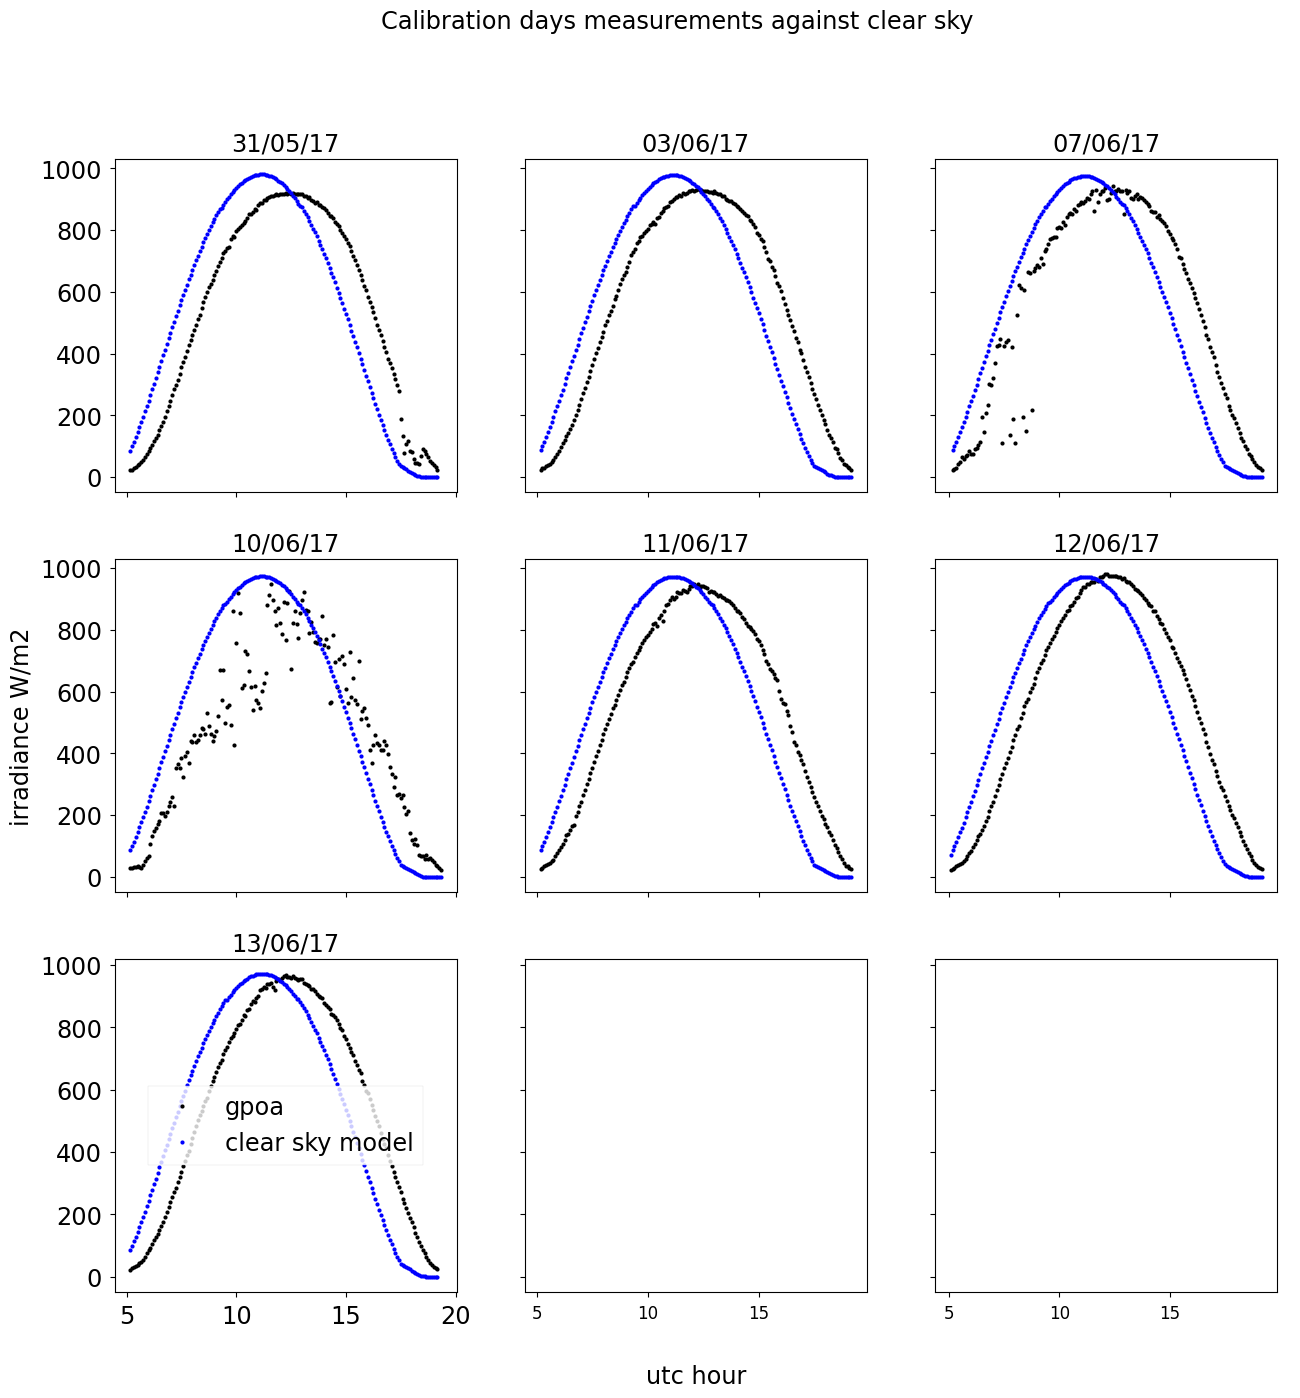

In [37]:
#small delay expected due to 15 minute step (resolution) and averaging
if sst in execute:
    #plotting without applying the time shift
    lgn_labels = ['gpoa','clear sky model']
    suptitle = "Calibration days measurements against clear sky"
    #DEV NOTE 9/6/21 good legend position to be found
    irplt.plot_daily_measurements(mscss=mscss, titles=titles, lgn_labels=lgn_labels, suptitle=suptitle,
                                  bbox_to_anchor=None, loc=10)


# Stability analysis
To be continued in calibration analysis

In [38]:
def plot_stable_days(ms:pd.DataFrame, ms_flt:pd.DataFrame, sl:SolarLibrary):
    markers = ["y.","g.","r."]
    lgn_labels = ["clear sky", "stable", "unstable"]
    columns = ["irradiancetotalpoa","gpoa","gpoa"]
    #lazy could be merged
    if "date" not in ms.columns.to_list():
        dti = ms.index
        ms["date"] = dti.date
    if "date" not in ms_flt.columns.to_list():
        dti = ms_flt.index
        ms_flt["date"] = dti.date
    cs_dates = ms_flt.date.unique()
    mscss = []
    titles = []
    for d in cs_dates:
        ms_t = ms.copy()
        ms_t= ms_t[ms_t.date==d]
        mscs = csky.merge_meas_with_sp(ms_t, sl)
        mscs_flt = mscs[mscs.index.isin(ms_flt.index)]
        mscs_unf = mscs[~mscs.index.isin(ms_flt.index)]
        title = f'{d.strftime("%d/%m/%y")}'
        mscss.append([mscs, mscs_flt, mscs_unf])
        titles.append(title)
    irplt.plot_daily_measurements(mscss=mscss, titles=titles, lgn_labels=lgn_labels, suptitle=None,
                            columns=columns, markers=markers)

In [39]:
"""STABILITY PARAMETERS"""
# [ISO 9847]
AOI_MAX = 70
# 0.2 (20%): uncertainty 95% of HOURLY values for moderate quality (class C) radiometers [WMO 2017)
KCS_UNC = 0.2
# 3% (hourly class A) on 1000 also directional response ONLY on class C
G_UNC = 30
# adapted from 2% variation from average in [ISO 9847]
KCS_CV_MAX = 0.02
PWR_CV_MAX = 0.1
# strong correlation used for daily creiteria
PEARSON_MIN = 0.8
# daylight hours IEC 61724-1-2017
G_MIN = 20

itr = 1
#DEV NOTE 24/5/21 be careful keep labels different (or change structure) to avoid overwriting
steps = ["h"] #, "", "20min"]
# 20 instead of 21 to allow spot values per minute
periods = ["d"] # , "20min", "d"]
# minimum 15 series but on entire day
counts = [(3, 3)] #, 20, 15]
# not applied since too restrictive for low elevation, due also to possible dt shift
kcs_uncs = [None] #* itr
#applying instead g_unc, double accounting for pyranometer and cs model calibrated on pyranometers
g_uncs = [None] #* itr
# Pearson applied only for lower resolution
pearson_mins = [PEARSON_MIN] #, None, None]
# CV analysis only on series not for initial filtering
kcs_cv_maxs = [None] #, None, KCS_CV_MAX]
# separately defining the ones not needing comments

## Showing stability analysis for one system

In [40]:
# most probable dataset tz from previous analysis
tzi = "utc"
sst = "Trentino Alto Adige horizontal"

if "Trentino Alto Adige" in sst:
    #using calibration dates as test
    cs = dfus[sst].copy()
    if "date" not in cs.columns.to_list():
        dti = pd.DatetimeIndex(cs.dt.rename('index'))
        cs.index = dti
        cs["date"] = dti.date
        cs = cs[cs.date.isin(cs_dates)]
cs.head(1)

,dt,gpoa,date
index,,,
2017-05-31 00:07:30+00:00,2017-05-31 00:07:30+00:00,NaN,2017-05-31


In [41]:
if sst in execute:
    (dfc, sl, g_mins, aoi_maxs) = (cs, sls[sst], [G_MIN] * itr, [AOI_MAX] * itr)

    ms, ms_flt, ms_grps  = csky.stabilityflagging(ms_utc=cs, sl=sl, steps=steps, periods=periods, counts=counts,
        g_mins=g_mins, aoi_maxs=aoi_maxs, kcs_uncs=kcs_uncs, pearson_mins=pearson_mins, kcs_cv_maxs=kcs_cv_maxs,
        g_uncs=g_uncs) #, pwr_cv_maxs=pwr_cv_maxs) #, cs_columns=cs_columns)

Started 'stabilityflagging' at 2021-07-04 19:47:24.252475
672 rows. Extracting h data before d grouping of min 6 valid values
Started 'get_parameters_timed' at 2021-07-04 19:47:24.402474
Finished 'get_parameters_timed' in 0:00:00.058006 secs
Validation done with g_min,aoi_max. Filtering for values count,pearson
No clear sky data after d period filter
Finished 'stabilityflagging' in 0:00:00.245001 secs


Legend: loc (0, 0), bbox_to_anchor (0, -1)
030617.jpg saved at C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance/outputs/figures/
Legend: loc (0, 0), bbox_to_anchor (0, -1)
070617.jpg saved at C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance/outputs/figures/
Legend: loc (0, 0), bbox_to_anchor (0, -1)
100617.jpg saved at C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance/outputs/figures/
Legend: loc (0, 0), bbox_to_anchor (0, -1)
110617.jpg saved at C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance/outputs/figures/
Legend: loc (0, 0), bbox_to_anchor (0, -1)
120617.jpg saved at C:\Users\wsfm\OneDrive - Loughborough University\_Personal_Backup\python_repositories\ground-based-solar-irradiance/outputs/figures/
Legend: loc (0, 0), 

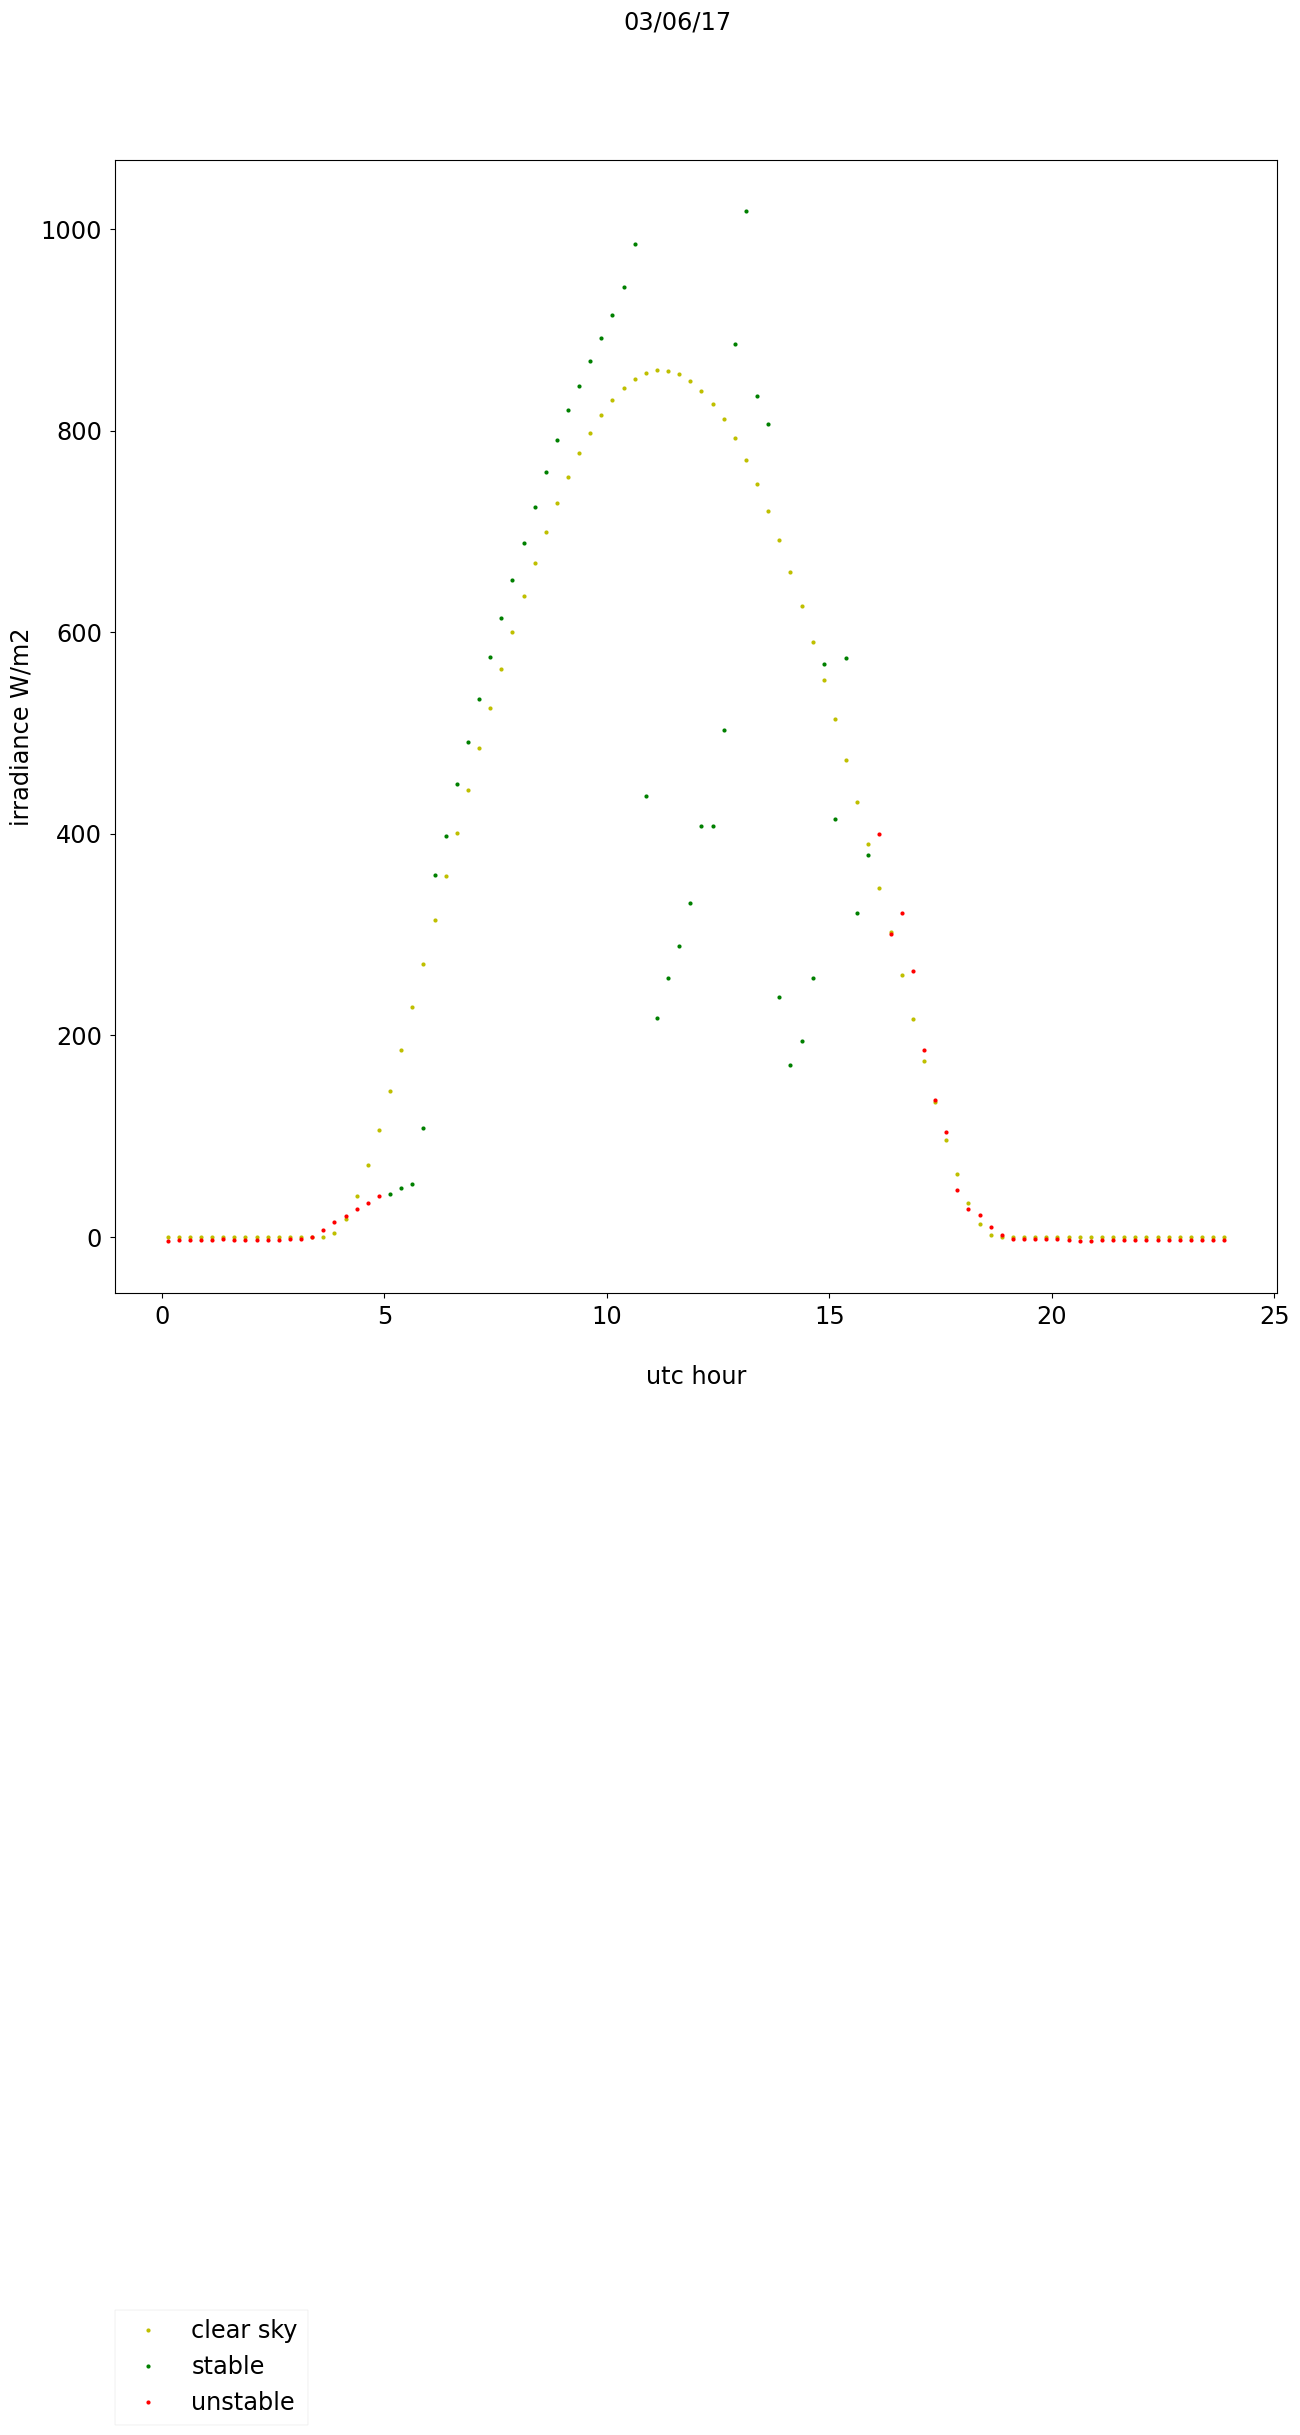

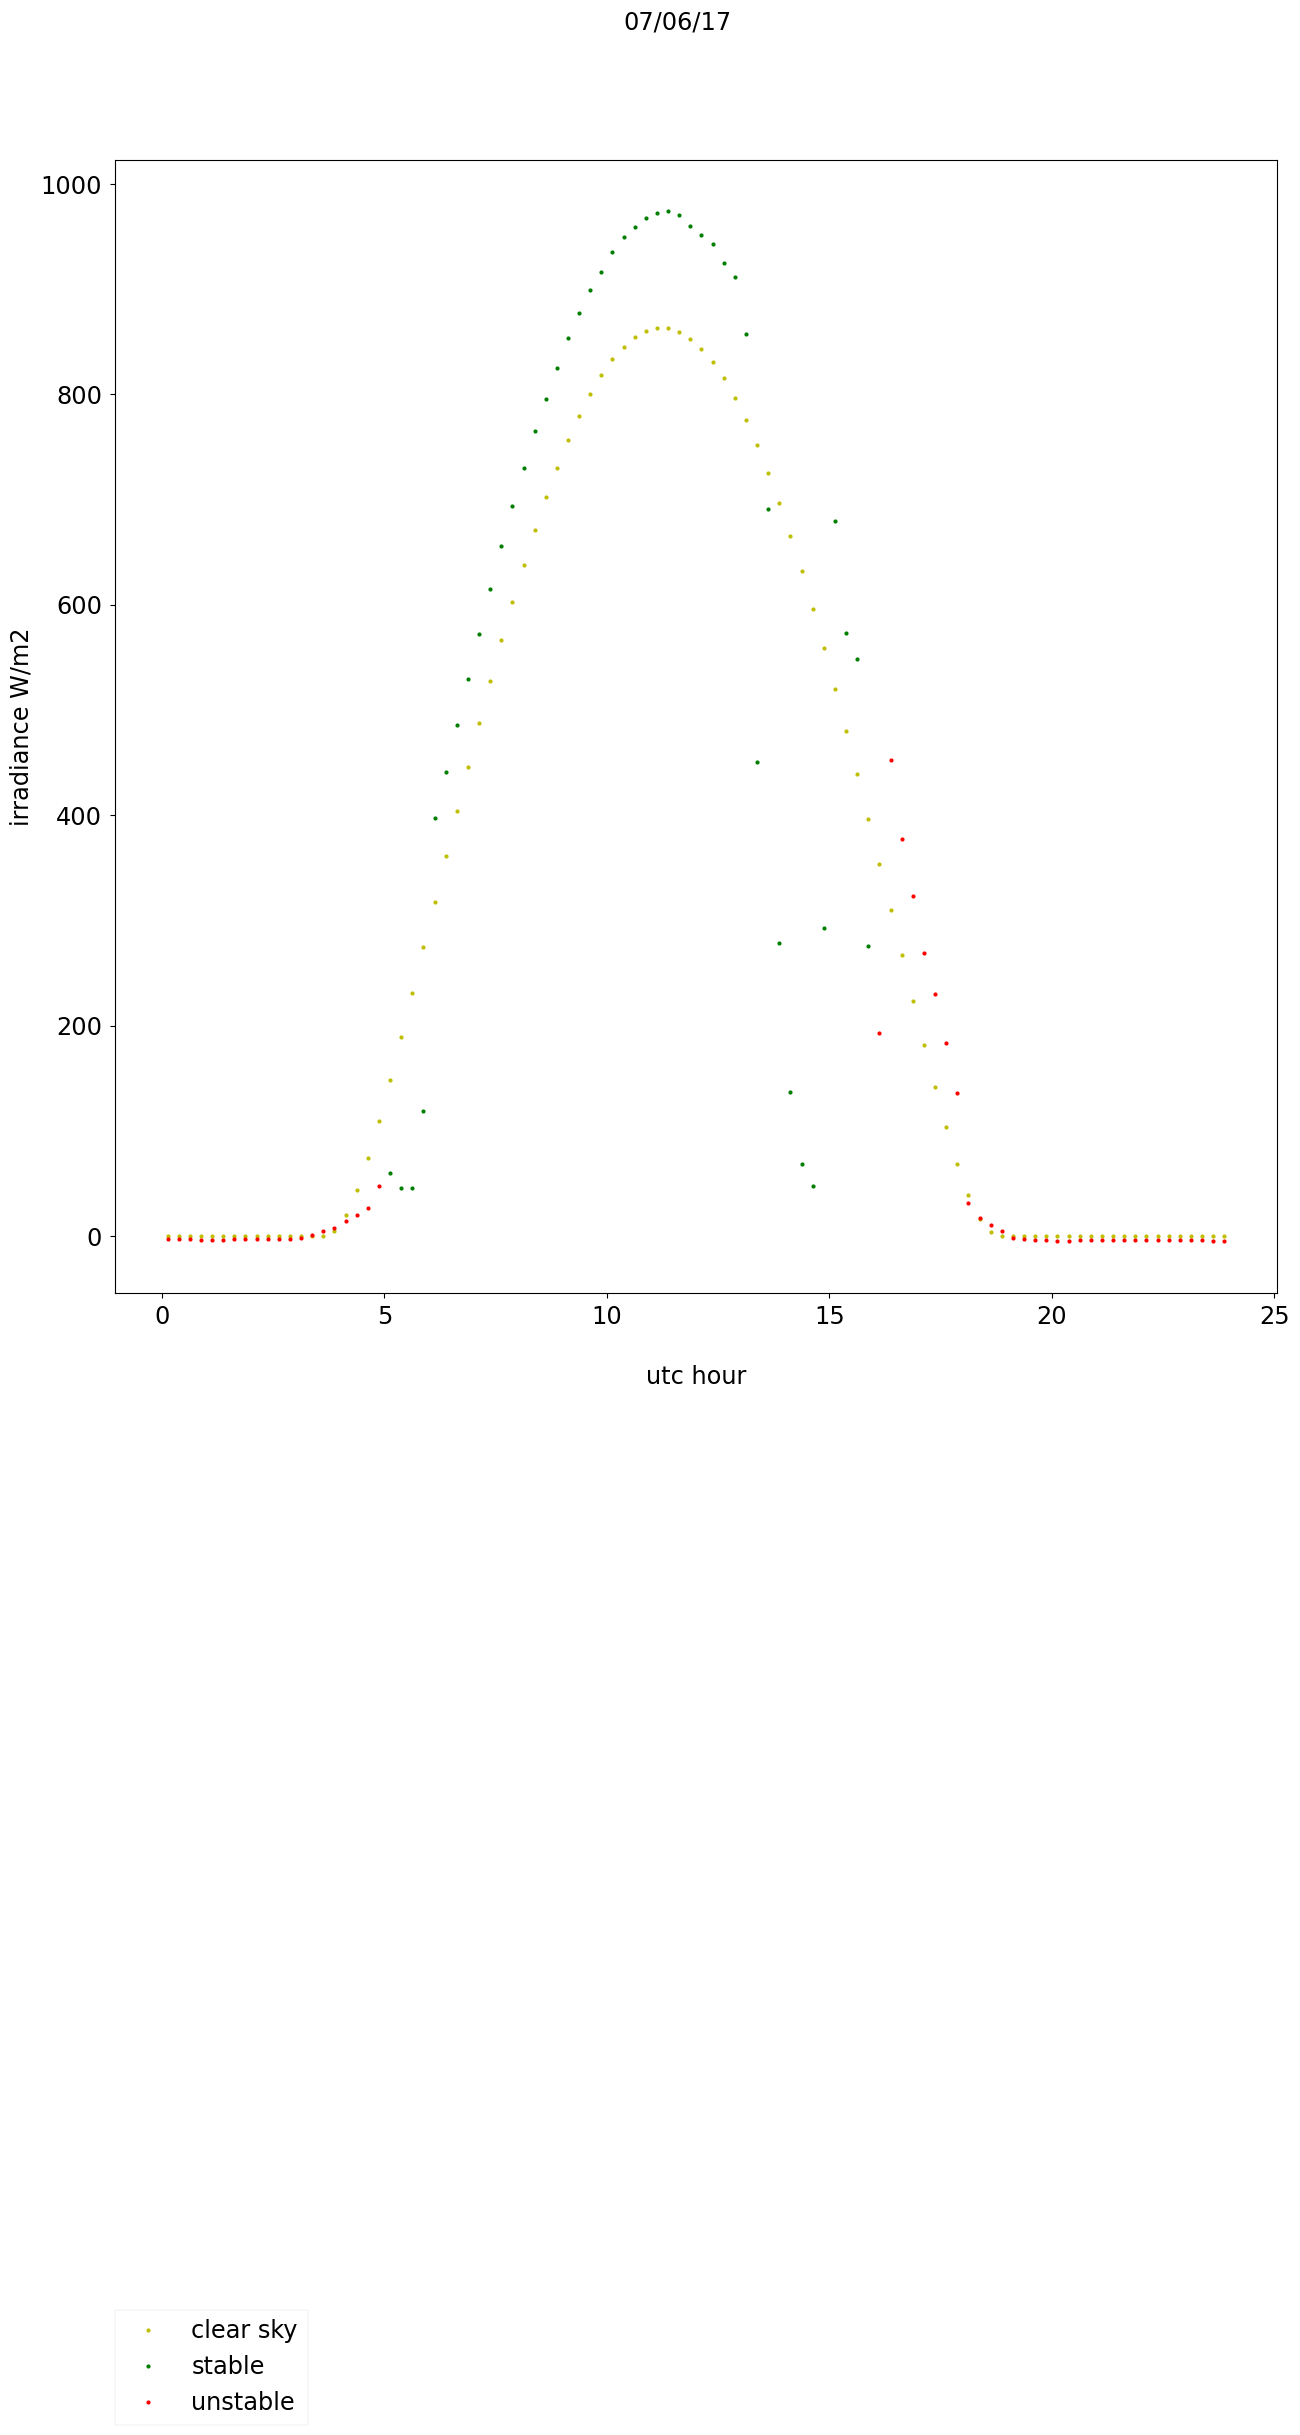

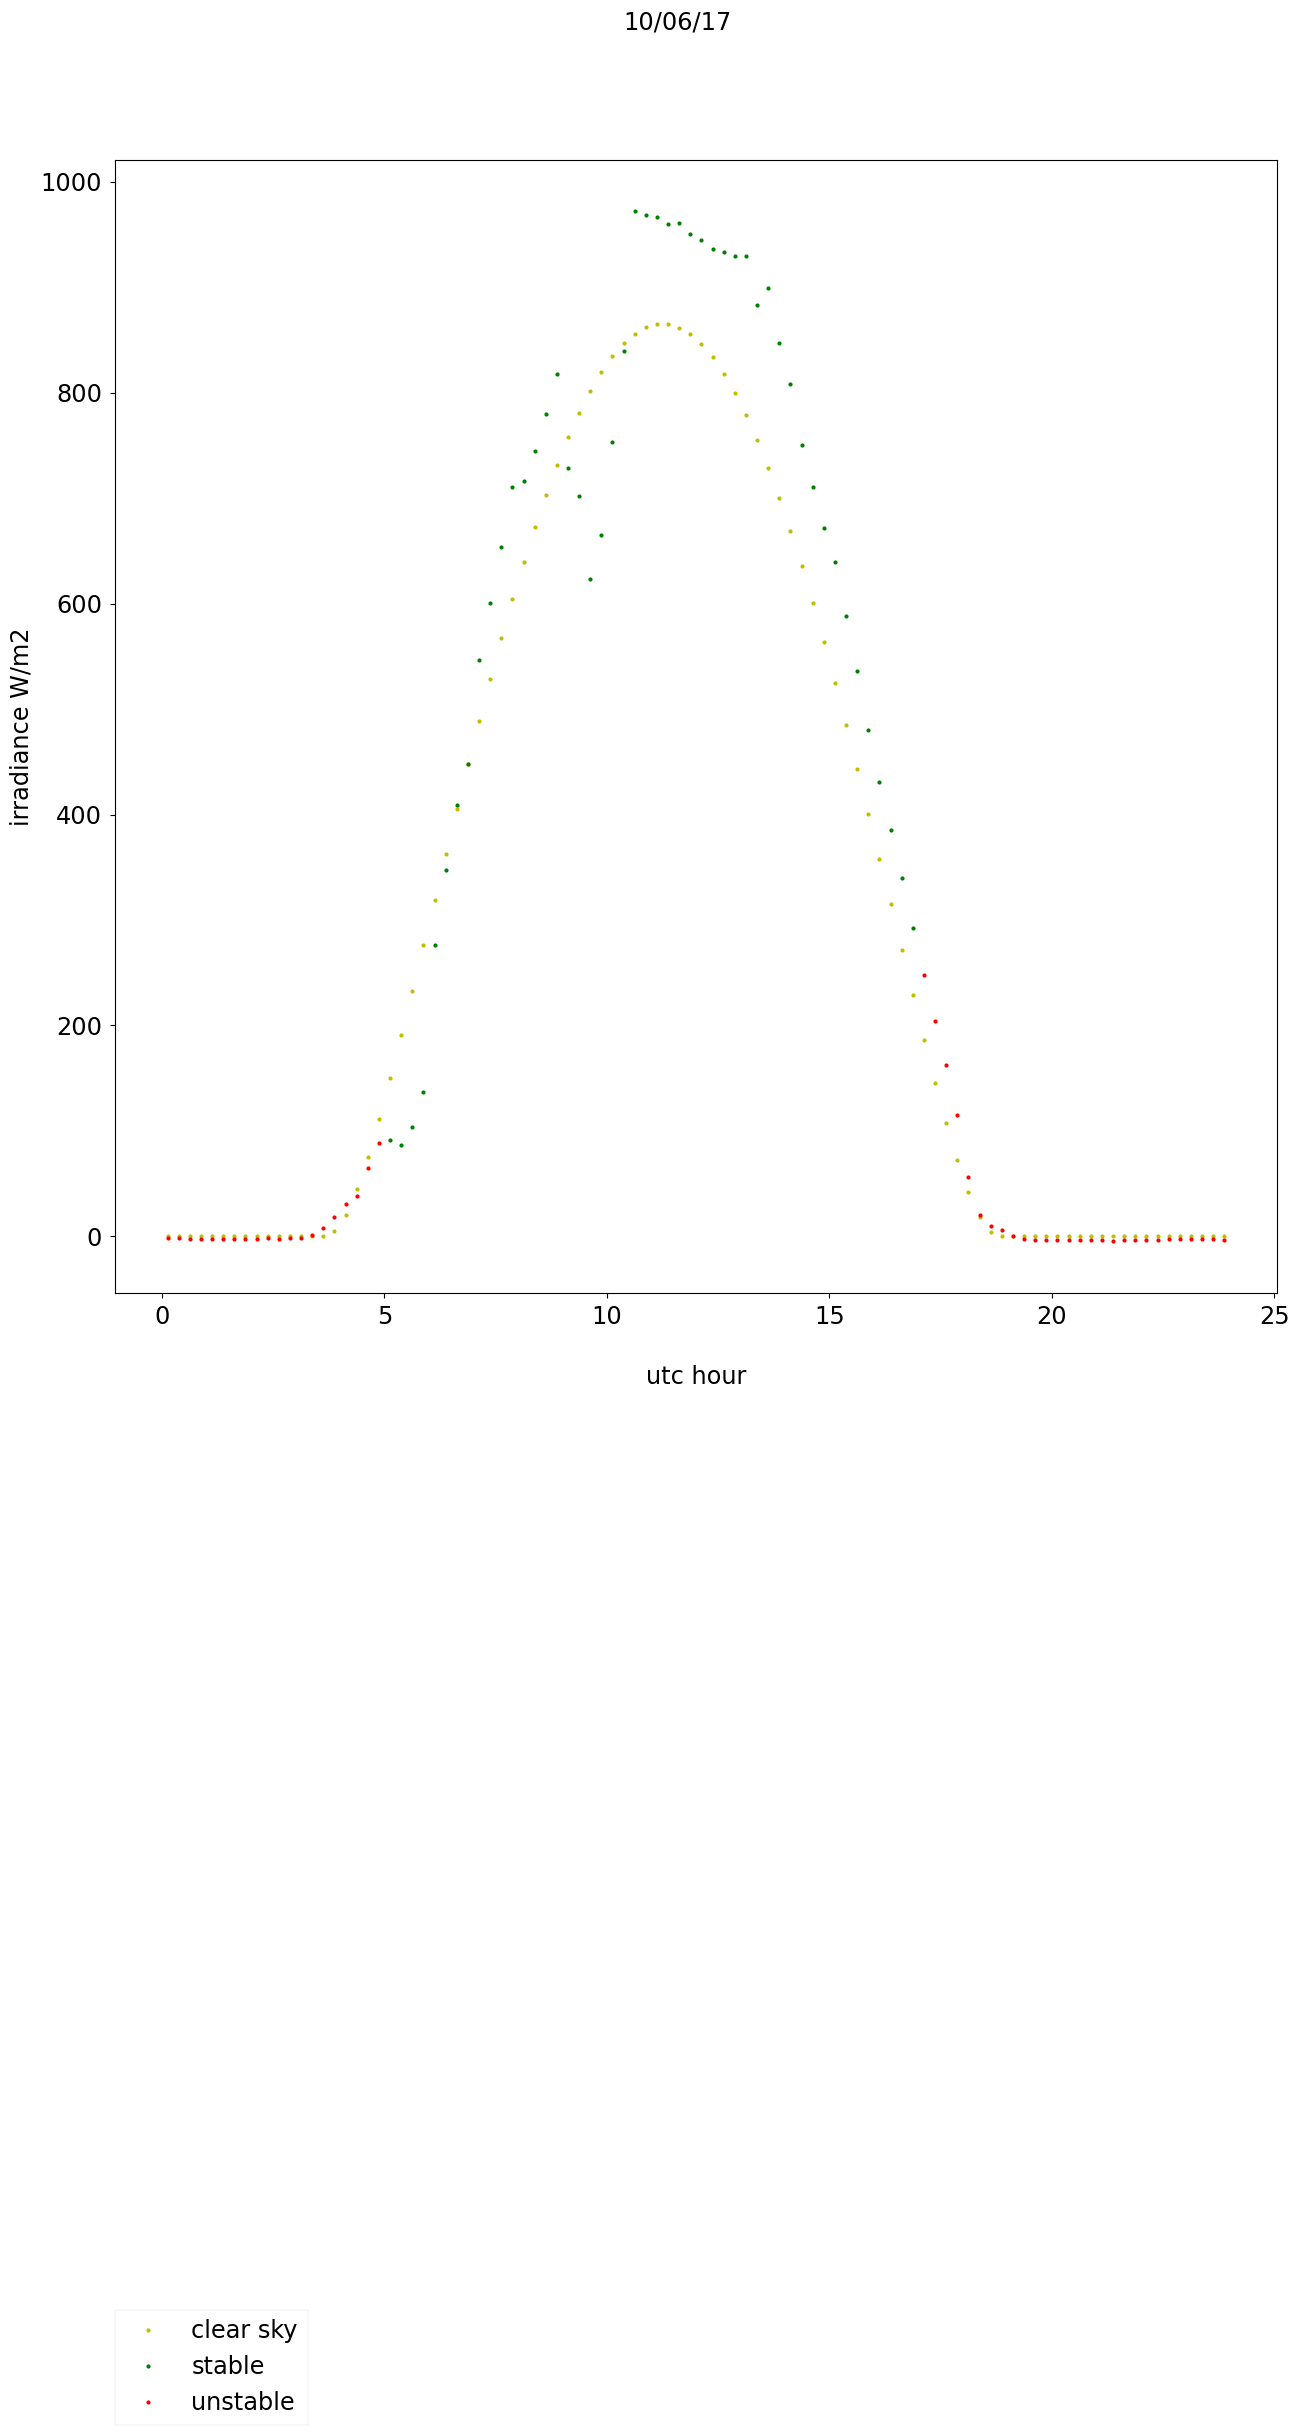

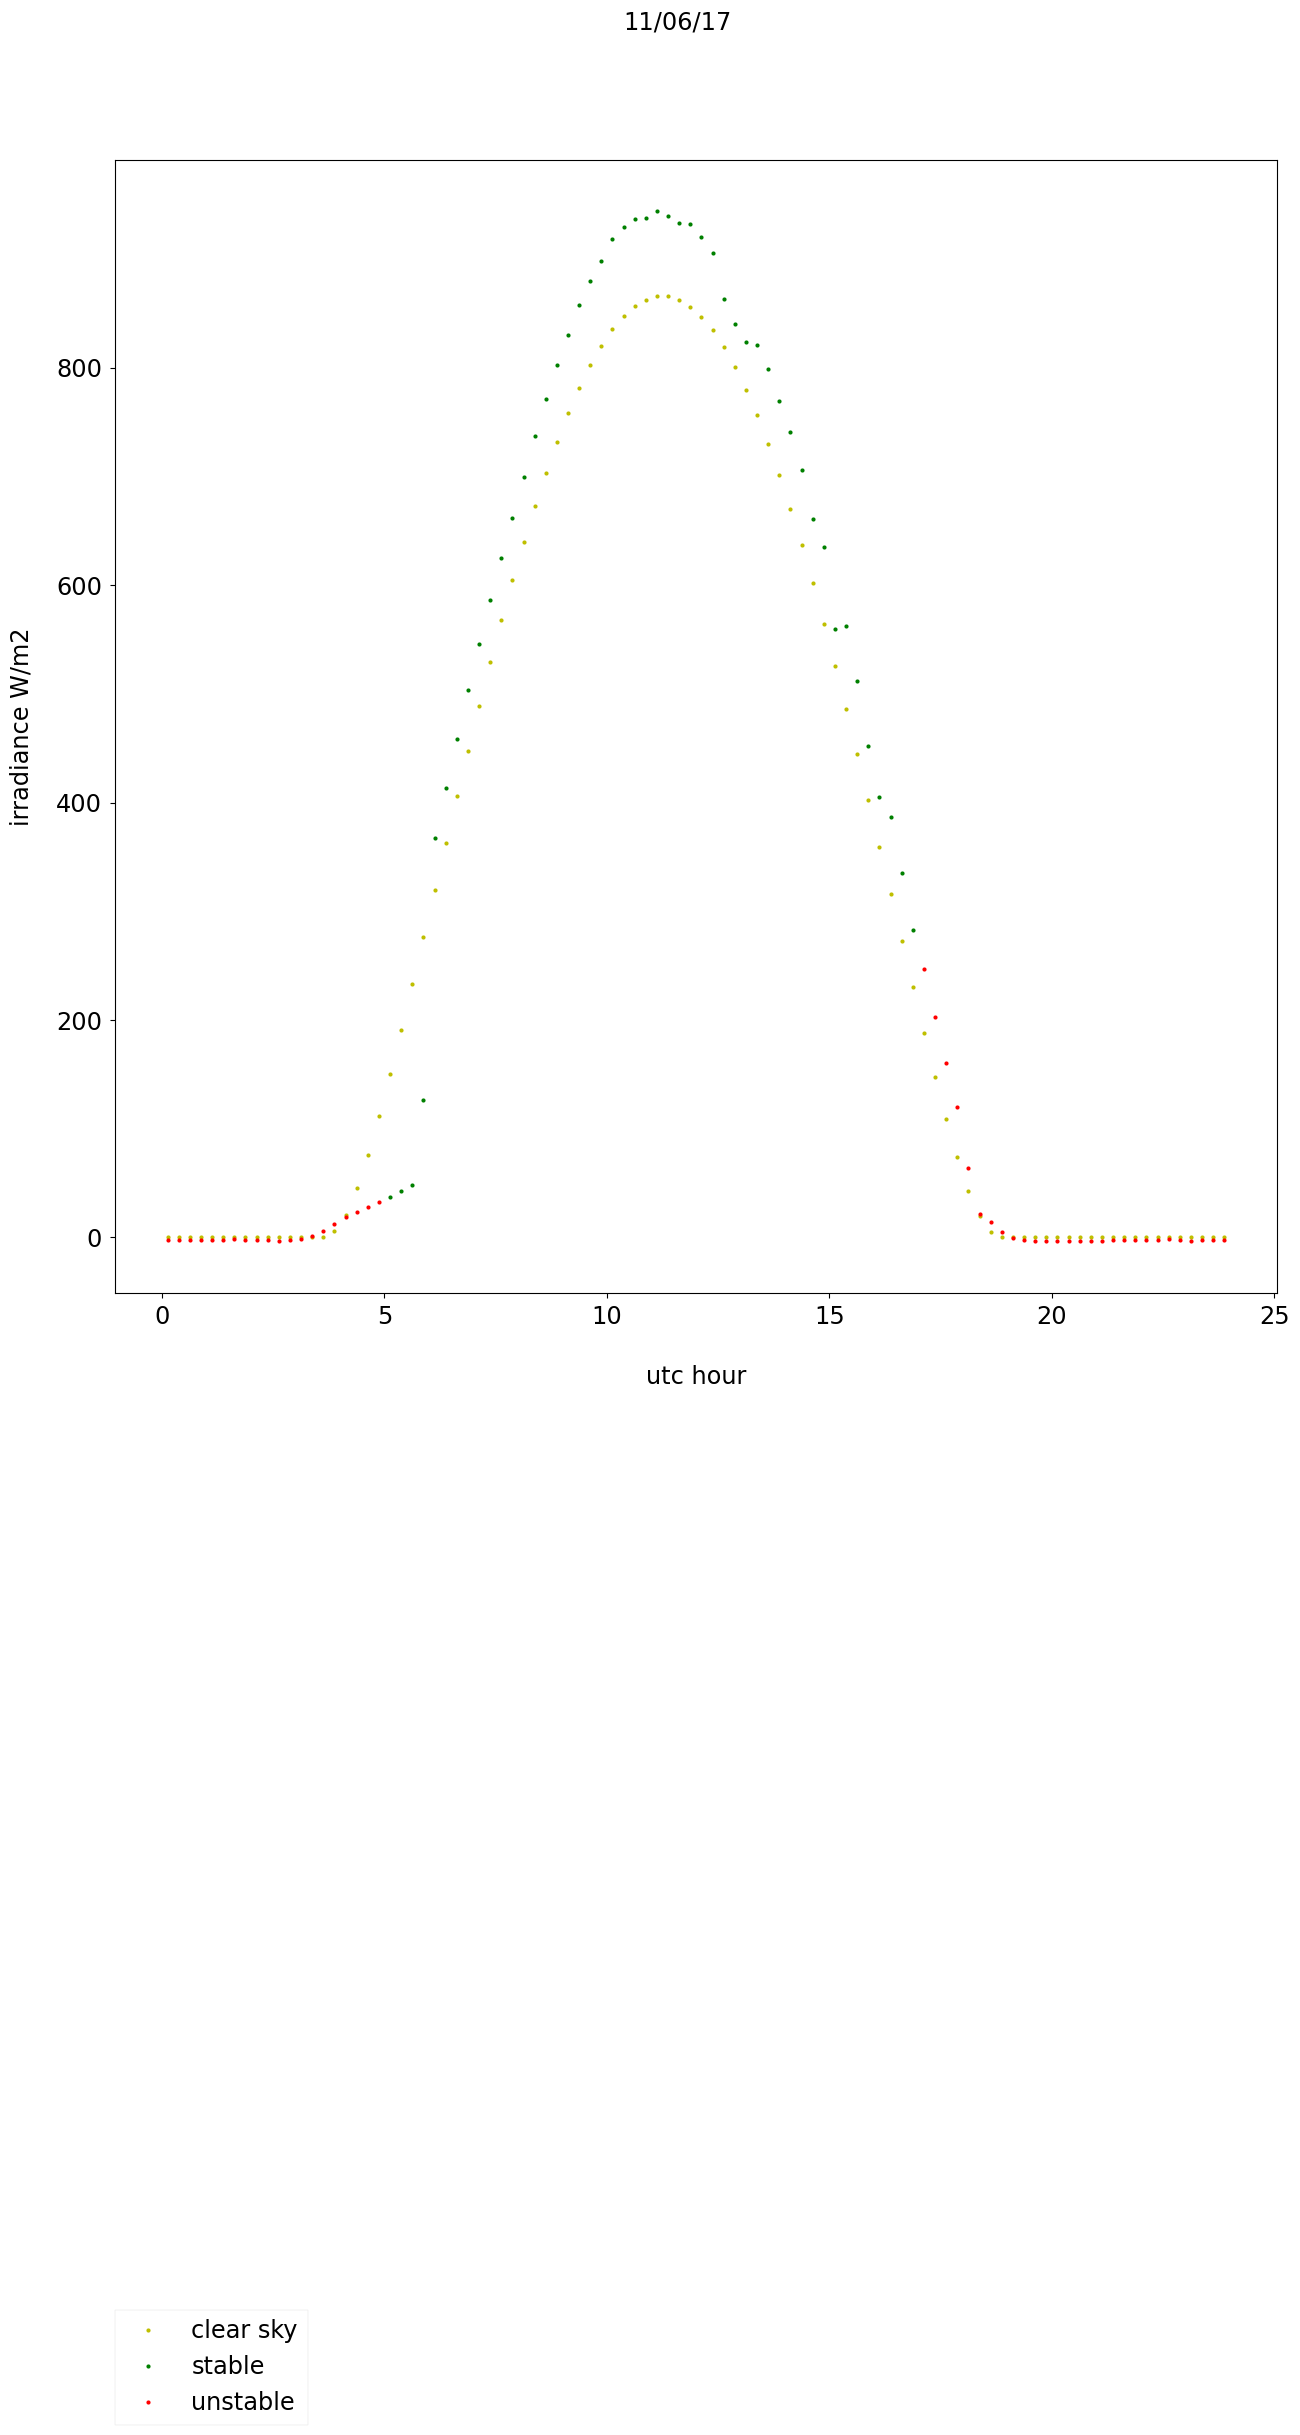

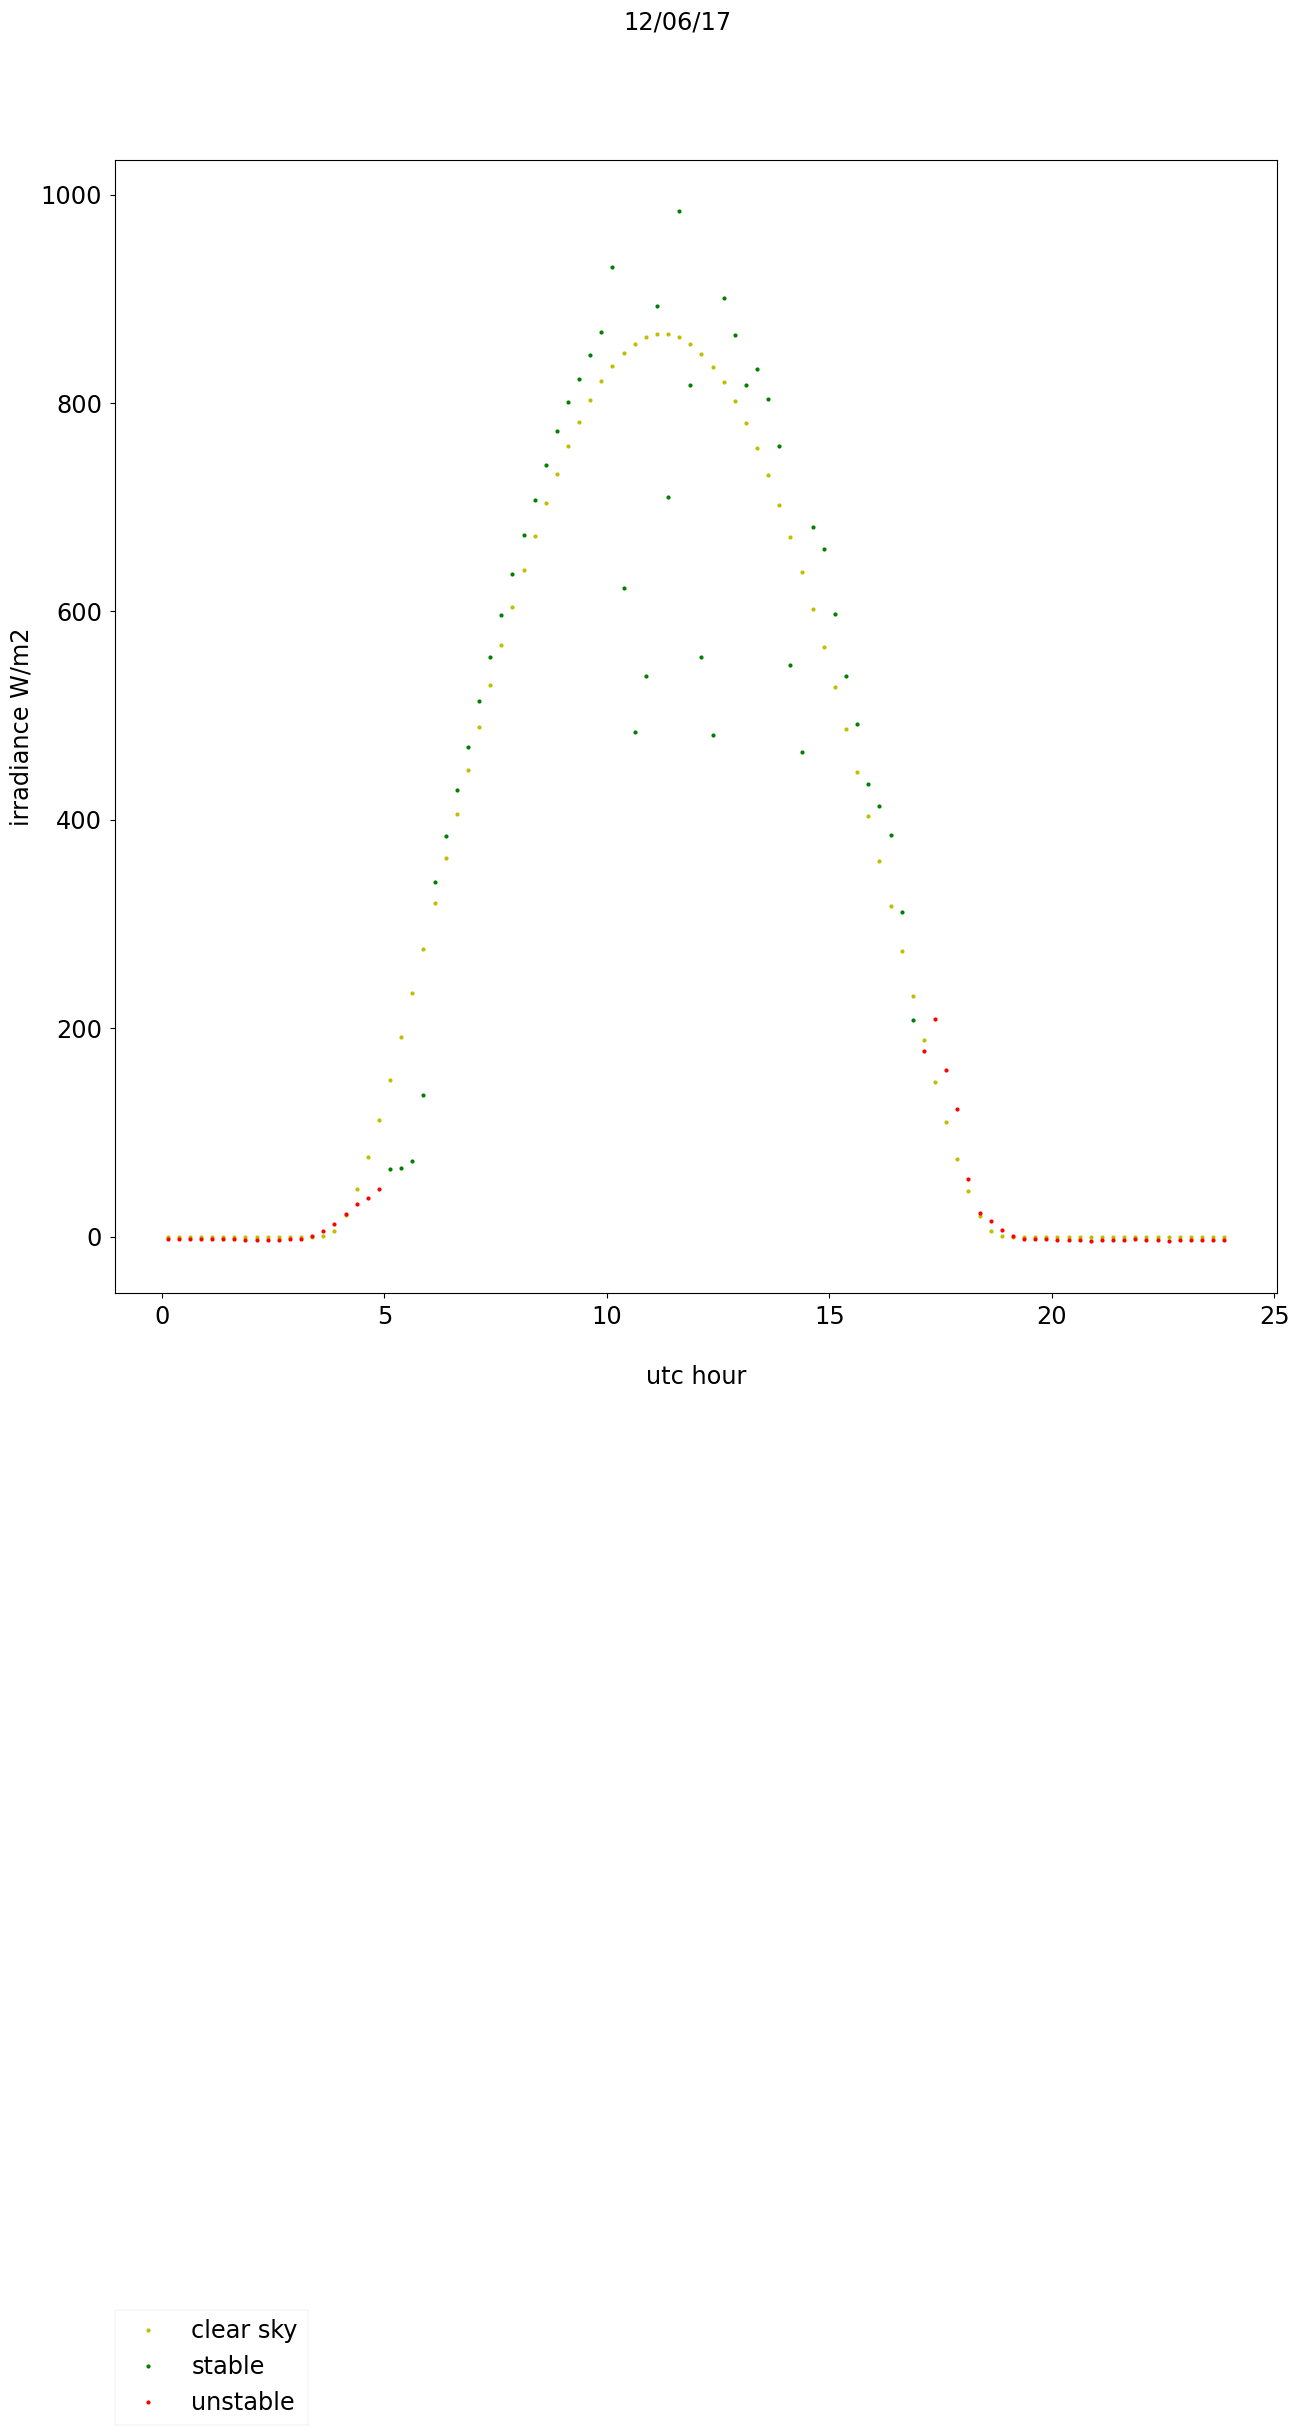

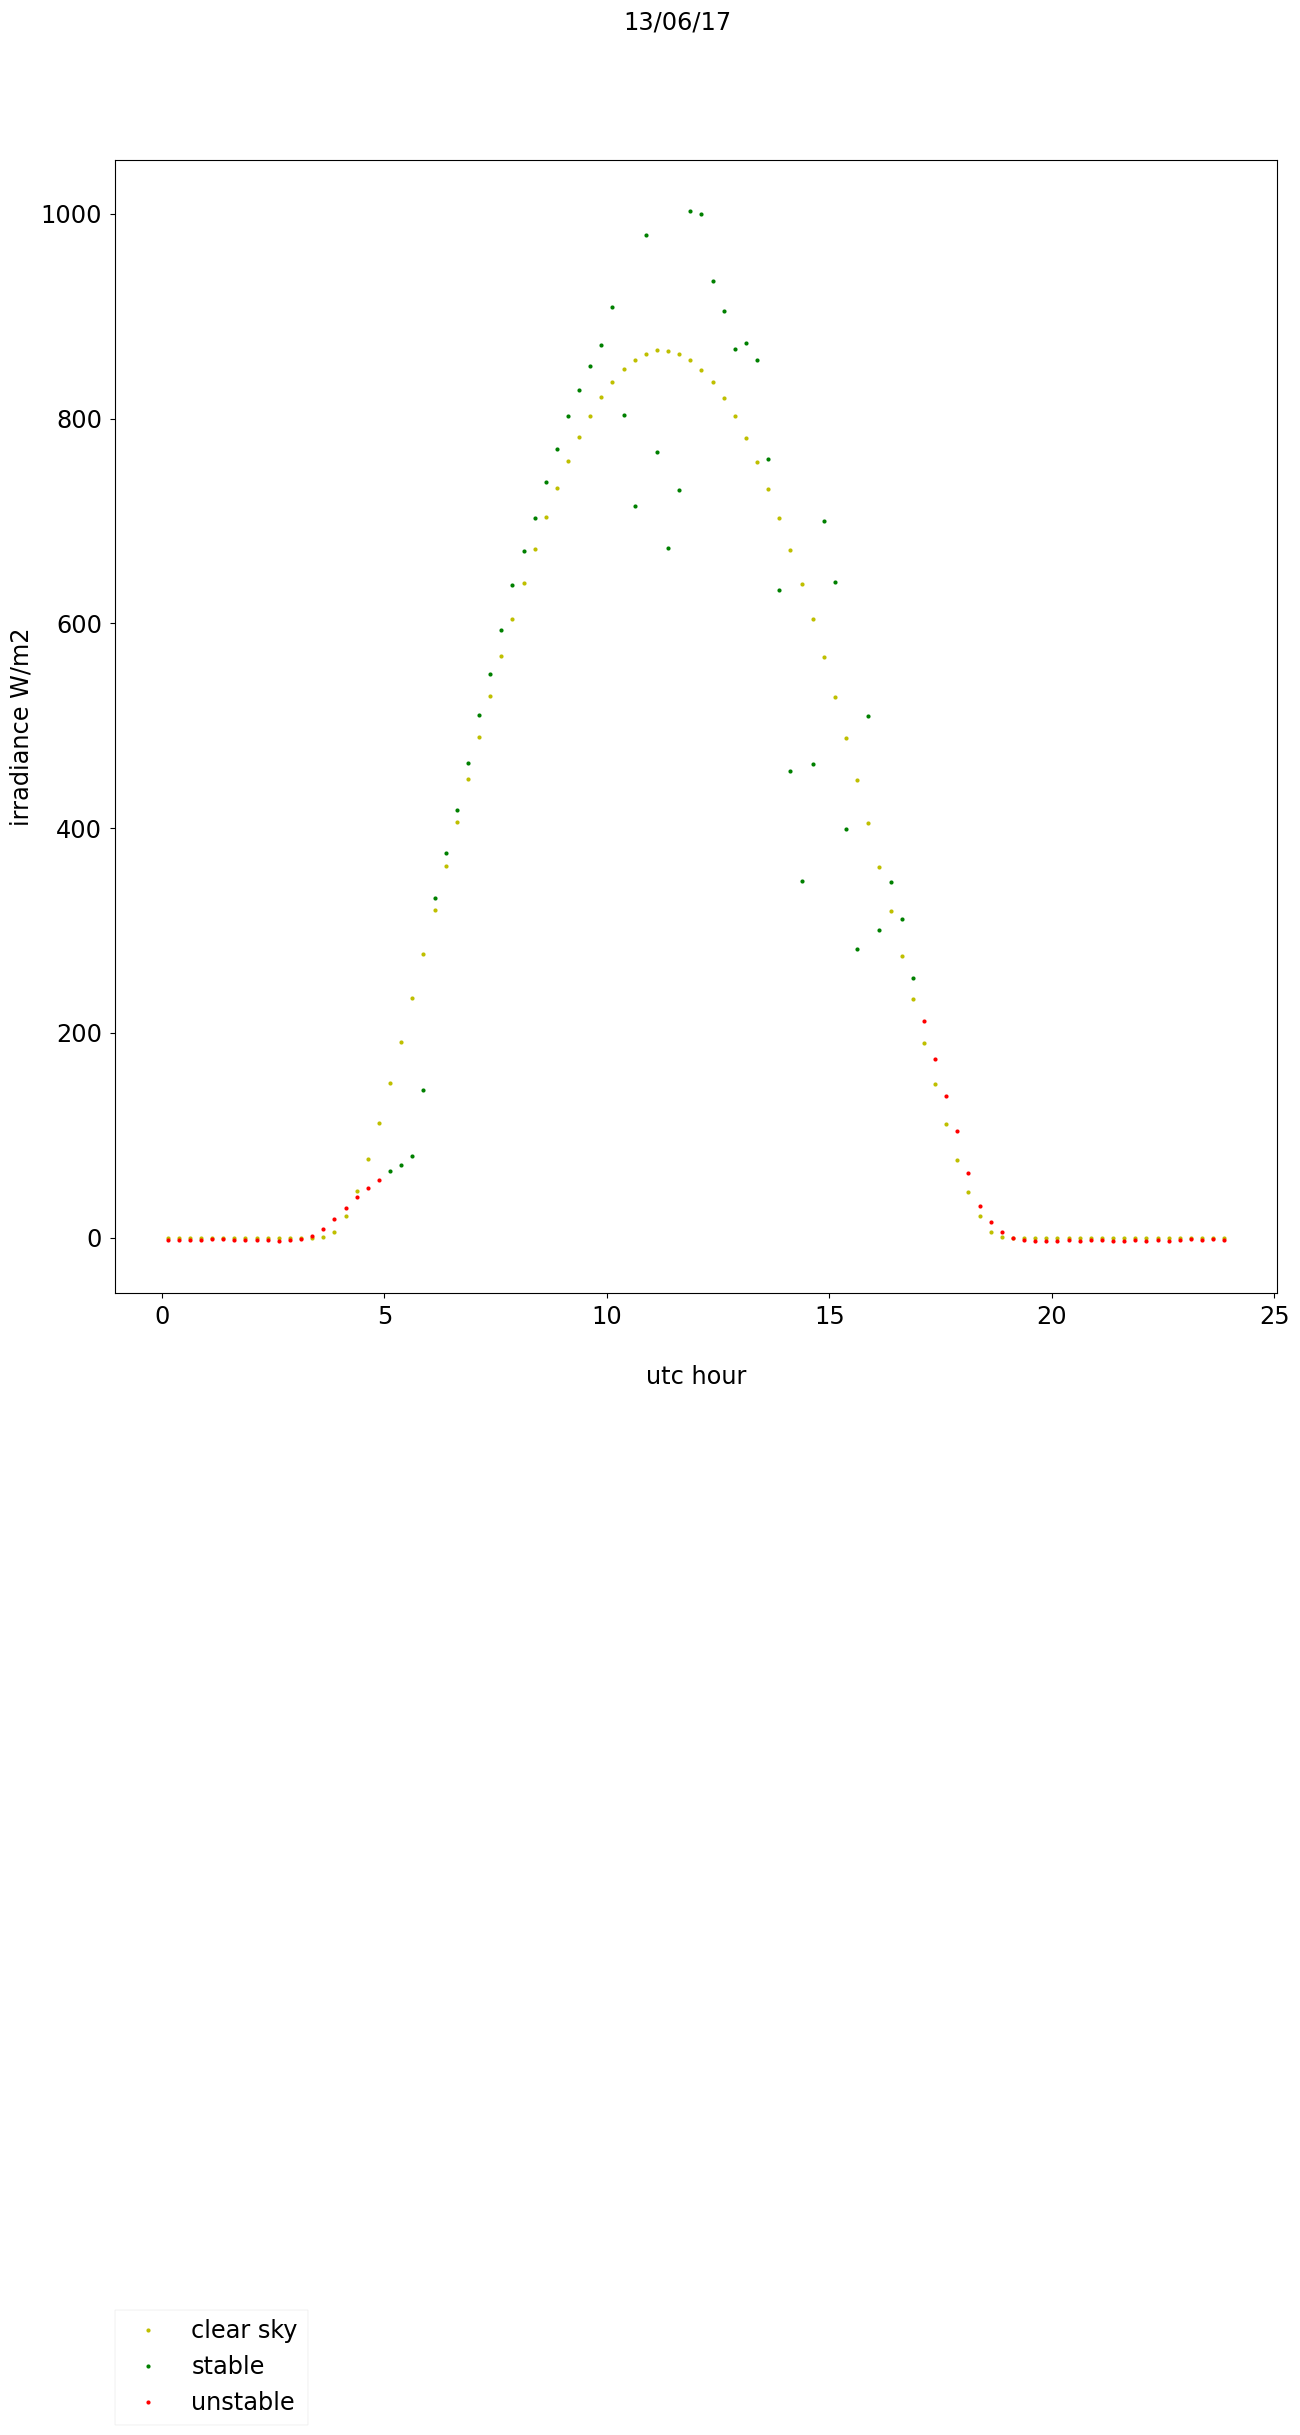

In [42]:
plot_stable_days(ms, ms_flt, sl)


def plot_dates_tzi_shifts_old(df_c:pd.DataFrame, delays:pd.DataFrame, sl:SolarLibrary, plt_prm=None, label=None,
                subplots=False):
    #plot parameter for slightly changing the graph during test
    if subplots:
        n = len(delays)
        columns = int(round(n**0.5, 0))
        rows = int(np.ceil(n/columns))
        #https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_star_poly.html#sphx-glr-gallery-lines-bars-and-markers-scatter-star-poly-py
        fig, axs = plt.subplots(rows, columns, sharex='col', sharey='row', figsize=(15,15))
        #plot counter
        p=0
    #completeness before since disconnections maybe from one period to another one
    dti = pd.DatetimeIndex(df_c.dt)
    df_c.loc[:,'date'] = dti.date
    fig_title = 'Comparison of candidate timezones and datetime delays'
    if label is not None:
        fig_title += f" for {label} pyranometer"


    for i, r in delays.iterrows():
        #r["tz","time","shift_h","d_product_min_date","d_product_min_value"]
        tz, time, shift_h, d, prd = r["tz"],r["time"],r["shift_h"],r["d_product_min_date"],r["d_product_min_value"]
        df = df_c.copy(deep=True)
        # selecting by date
        df = df[df.date==d]
        #applying test time shift_h
        df['dt'] = df['dt'].apply(lambda x: x + datetime.timedelta(seconds=int(60*60*shift_h)))
        #converting index before merging
        df.index  = dtop.reset_tzi_convert_tze(df.loc[:,'dt'].rename("dt_tz"), tz, sl.timezone)
        #mscs = csky.merge_meas_with_sp(df, sl)
        mscs = csky.merge_meas_with_sp(df, tz, sl)
        # {prd:.2f}
        title = f'{tz} {shift_h}, {d.strftime("%d/%m/%y")}({time[0]})'

        if subplots:
            row = int((p)/columns)
            column = int(p % columns)
            if columns > 1:
                ax = axs[row, column]
            #elif columns == 1:
            else:
                ax = axs[p]
            p+=1
        else:
            fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(15,15))
            fig_title = f"{label} pyranometer "+title
            title = ""
        plot_meas_day(mscs, ax, title)
        if subplots == False:

            finalise_subplots(fig, ax, fig_title, lgn_labels=['gpoa','clear sky model'], plt_prm='')
        #raw solution
    #external to cycle so if empty still same position
    if subplots:
        if columns > 1:
            #using first graph
            ax = axs[rows-1, 0]
        else:
            ax = axs[n-1]
        finalise_subplots(fig, ax, fig_title, lgn_labels=['gpoa','clear sky model'], plt_prm='')

#absolute comparison
#re-merge for overall analysis
utc_mrg_cmps = [pd.concat([w, s], sort=True) for w, s in utc_cmps]
axs_values = irplt.plot_monthly_delays(cmps=utc_mrg_cmps, labels=labels, sl_tzi=tzs_v, parameters=parameters, timezone_label="utc")

#ttzs found
tzs_f = {}
for e in execute:
    #assignign most probable timezone using dsc
    def get_delay_trn(dsc,e): return abs(dsc.loc[e,"delay_transit_h_s"])+abs(dsc.loc[e,"delay_transit_h_w"])
    delay_trn_utc = get_delay_trn(dsc_utc,e)
    delay_trn_tz = get_delay_trn(dsc_tz,e)
    #https://stackoverflow.com/questions/14091636/get-dict-key-by-max-value
    #tzi = min(delay_trn_0, key=delay_trn_0.get)
    if delay_trn_tz < delay_trn_utc: tzs_f[e] = sls[e].timezone
    else: tzs_f[e] = 'utc'
print(tzs_f)

# TBC later selection for calibration days for other systems

In [43]:
sst == "Trentino Alto Adige horizontal "
if sst in execute:
    #using calibration dates as test
    sl_0 = sls[sst]
    tzi = sl_0.timezone
    #reset need tz df
    delays_0 = iran.get_sunpath_delays(cmp_sp_tz=mrg_cmps[5], shifts=[0], tzi=[tzi], sl =sl_0,
                                            sunpath_filter=True, dates=True)

NameError: name 'mrg_cmps' is not defined

In [ ]:
#selecting candidates days for summer and winter
cs_dates_0 = [ds for ds in delays_0.dates.values[0]]+[ds for ds in delays_0.dates.values[1]]
print(len(cs_dates_0))

In [ ]:
if sst in execute:
    irplt.plot_delay_dates_tzi_shifts(df_c=dfcs[sst], delays=delays_0, sl=sls[sst], plt_prm=None, label=sst,subplots=False)